Using random seed: 391665487
Generating a 100x100 maze with 30.0% dead end factor and target dead end length of 8...
Generated Maze:
Walls: 49.1% of the maze
Open cells: 5092 out of 10000


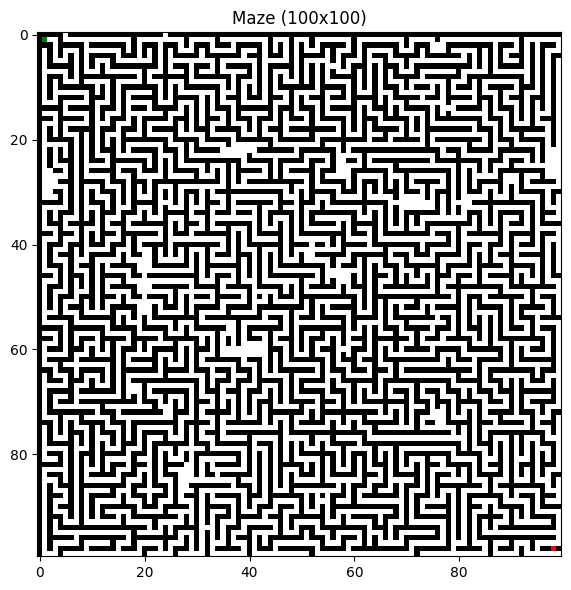

Running A* Search...
A* Search Time: 0.003998 seconds
A* Path Length: 483
A* Explored Nodes: 1281
A* Search Path:


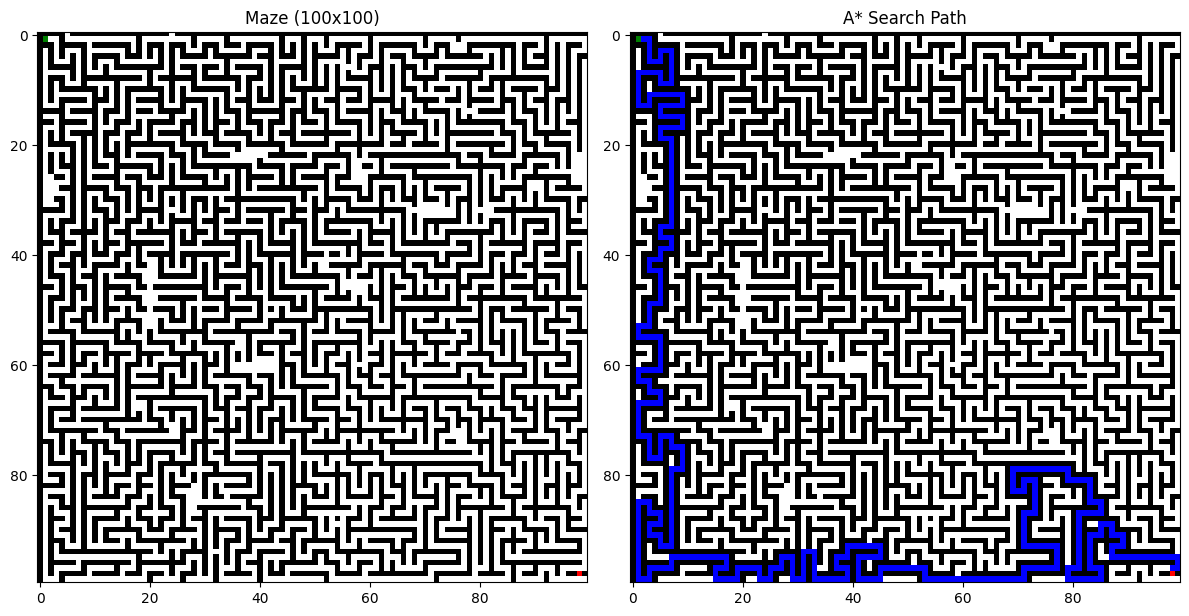

Running Quantum Search using Grover's algorithm...
Quantum Search Time: 0.138870 seconds
Number of Qubits Used: 4
Search Space Size: 16 positions
Estimated Grover Iterations: 4
Quantum Path Length: 483
Found Goal Position: (97, 99)
Actual Goal Position: (98, 98)
Comparison of Search Paths:


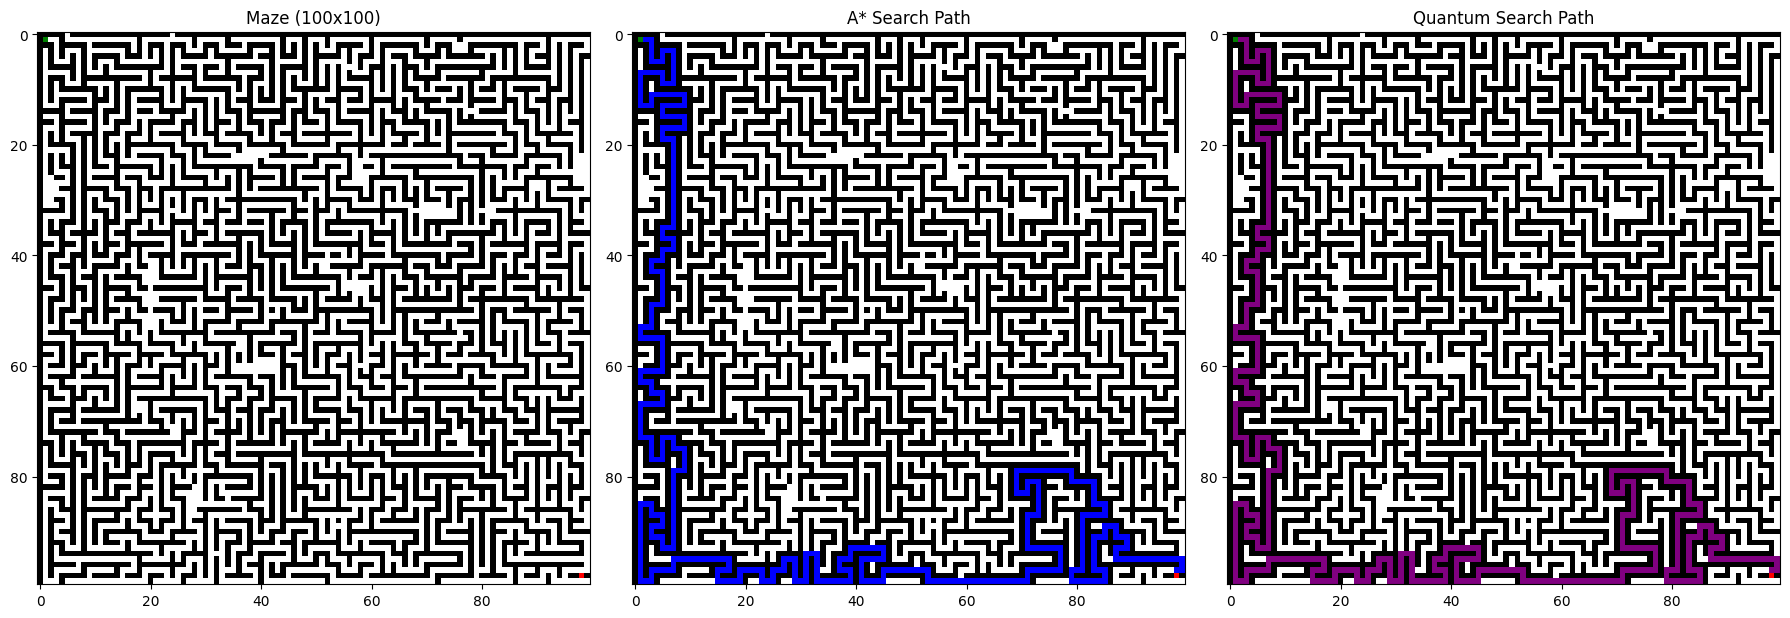


--- Performance Comparison ---
Classical A* Complexity: 1281 nodes explored
Quantum Complexity: 4 iterations
Theoretical Quantum Speedup: 4.00x
Actual Runtime Ratio (A*/Quantum): 0.03x
Note: The quantum simulation is running on classical hardware.
On actual quantum hardware, the theoretical speedup would be more relevant.

--- Maze Analysis ---
Average Branching Factor: 2.05
Optimal Path Length: 483
Path Length / Maze Diagonal Ratio: 4.83
Estimated Maze Complexity Score: 4.87 (higher is more complex)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import heapq
import time
import math
import random
import uuid
from qiskit import Aer, QuantumCircuit, execute, transpile
from qiskit.algorithms import AmplificationProblem
from qiskit.circuit.library import PhaseOracle
from qiskit.primitives import Sampler
from qiskit.algorithms.amplitude_amplifiers import Grover
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import QasmSimulator

class Maze:
    def __init__(self, width, height, dead_end_factor=0.15, dead_end_length=5):
        self.width = width
        self.height = height
        self.dead_end_factor = dead_end_factor
        self.dead_end_length = dead_end_length
        self.walls = set()
        self.start = (1, 1)
        self.goal = (width - 2, height - 2)
        
    def is_wall(self, x, y):
        return (x, y) in self.walls
    
    def get_neighbors(self, x, y):
        neighbors = []
        for nx, ny in [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]:
            if 0 <= nx < self.width and 0 <= ny < self.height and not self.is_wall(nx, ny):
                neighbors.append((nx, ny))
        return neighbors

    def generate_maze(self):
        for x in range(self.width):
            for y in range(self.height):
                self.walls.add((x, y))
        self.walls.remove(self.start)
        self.walls.remove(self.goal)
        self._generate_maze_recursive(self.start[0], self.start[1])
        self._ensure_path_exists()
        dead_end_count = int(self.width * self.height * self.dead_end_factor)
        self._add_long_dead_ends(dead_end_count)
        self._add_branching_paths()
        self._create_alternate_paths()
    
    def _generate_maze_recursive(self, x, y):
        directions = [(2, 0), (0, 2), (-2, 0), (0, -2)]
        random.shuffle(directions)
        if random.random() < 0.4:
            goal_direction = None
            if abs(x - self.goal[0]) > abs(y - self.goal[1]):
                goal_direction = 0 if x < self.goal[0] else 2
            else:
                goal_direction = 1 if y < self.goal[1] else 3
            if goal_direction is not None:
                direction_to_move = directions[goal_direction % len(directions)]
                directions.remove(direction_to_move)
                directions.append(direction_to_move)
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.width and 0 <= ny < self.height and (nx, ny) in self.walls:
                self.walls.remove((nx, ny))
                self.walls.remove((x + dx//2, y + dy//2))
                self._generate_maze_recursive(nx, ny)
    
    def _ensure_path_exists(self):
        path = self._a_star_search()
        if not path:
            current = self.start
            steps_away = 0
            while current != self.goal:
                x, y = current
                possible_moves = []
                for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        dist_to_goal = abs(nx - self.goal[0]) + abs(ny - self.goal[1])
                        possible_moves.append(((nx, ny), dist_to_goal))
                possible_moves.sort(key=lambda m: m[1])
                if steps_away < 3 and len(possible_moves) > 1 and random.random() < 0.4:
                    move = possible_moves[1][0]
                    steps_away += 1
                else:
                    move = possible_moves[0][0]
                    steps_away = 0
                nx, ny = move
                self.walls.discard((nx, ny))
                current = (nx, ny)
    
    def _add_long_dead_ends(self, num_dead_ends):
        for _ in range(num_dead_ends):
            open_cells = [(x, y) for x in range(self.width) for y in range(self.height) 
                          if (x, y) not in self.walls and (x, y) != self.start and (x, y) != self.goal]
            if not open_cells:
                break
            valid_starting_points = []
            for cell in open_cells:
                x, y = cell
                for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.width and 0 <= ny < self.height and (nx, ny) in self.walls:
                        valid_starting_points.append(cell)
                        break
            if not valid_starting_points:
                continue
            cell = random.choice(valid_starting_points)
            self._create_dead_end_from(cell)
    
    def _create_dead_end_from(self, start_cell):
        x, y = start_cell
        length = self.dead_end_length + random.randint(-2, 3)
        length = max(3, length)
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        random.shuffle(directions)
        for dx, dy in directions:
            can_create = True
            path_cells = []
            for i in range(1, length + 1):
                nx, ny = x + i * dx, y + i * dy
                if not (0 <= nx < self.width and 0 <= ny < self.height and (nx, ny) in self.walls):
                    can_create = False
                    break
                path_cells.append((nx, ny))
            if can_create and path_cells:
                for cell in path_cells:
                    cx, cy = cell
                    non_wall_neighbors = 0
                    for ndx, ndy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                        ncx, ncy = cx + ndx, cy + ndy
                        if 0 <= ncx < self.width and 0 <= ncy < self.height and (ncx, ncy) not in self.walls:
                            non_wall_neighbors += 1
                    if non_wall_neighbors > 1:
                        can_create = False
                        break
            if can_create and path_cells:
                for cell in path_cells:
                    self.walls.remove(cell)
                self._add_turns_to_dead_end(path_cells)
                break
    
    def _add_turns_to_dead_end(self, path_cells):
        if len(path_cells) < 4:
            return
        num_turns = min(3, len(path_cells) // 4)
        for _ in range(num_turns):
            if len(path_cells) <= 4:
                break
            turn_index = random.randint(1, len(path_cells) - 3)
            turn_cell = path_cells[turn_index]
            x, y = turn_cell
            directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
            random.shuffle(directions)
            for dx, dy in directions:
                branch_length = random.randint(2, 4)
                can_branch = True
                branch_cells = []
                for i in range(1, branch_length + 1):
                    nx, ny = x + i * dx, y + i * dy
                    if not (0 <= nx < self.width and 0 <= ny < self.height and (nx, ny) in self.walls):
                        can_branch = False
                        break
                    branch_cells.append((nx, ny))
                if can_branch and branch_cells:
                    for cell in branch_cells:
                        self.walls.remove(cell)
                    break
    
    def _add_branching_paths(self):
        open_cells = [(x, y) for x in range(self.width) for y in range(self.height) 
                      if (x, y) not in self.walls]
        num_branches = int(math.sqrt(self.width * self.height) * 0.5)
        for _ in range(num_branches):
            if not open_cells:
                break
            cell = random.choice(open_cells)
            open_cells.remove(cell)
            self._create_branch_from(cell)
    
    def _create_branch_from(self, cell):
        x, y = cell
        branch_length = random.randint(3, 7)
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        random.shuffle(directions)
        for dx, dy in directions:
            branch_cells = []
            can_branch = True
            for i in range(1, branch_length + 1):
                nx, ny = x + i * dx, y + i * dy
                if not (0 <= nx < self.width and 0 <= ny < self.height):
                    can_branch = False
                    break
                if (nx, ny) not in self.walls:
                    can_branch = False
                    break
                branch_cells.append((nx, ny))
            if can_branch and branch_cells:
                for cell in branch_cells:
                    self.walls.remove(cell)
                if len(branch_cells) >= 3 and random.random() < 0.5:
                    sub_branch_point = random.choice(branch_cells[1:-1])
                    self._create_short_branch_from(sub_branch_point)
                break
    
    def _create_short_branch_from(self, cell):
        x, y = cell
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        random.shuffle(directions)
        for dx, dy in directions:
            branch_length = random.randint(2, 4)
            can_branch = True
            branch_cells = []
            for i in range(1, branch_length + 1):
                nx, ny = x + i * dx, y + i * dy
                if not (0 <= nx < self.width and 0 <= ny < self.height and (nx, ny) in self.walls):
                    can_branch = False
                    break
                branch_cells.append((nx, ny))
            if can_branch and branch_cells:
                for bc in branch_cells:
                    self.walls.remove(bc)
                break
    
    def _create_alternate_paths(self):
        walls_to_remove = int(math.sqrt(self.width * self.height) * 0.3)
        potential_walls = []
        for x in range(self.width):
            for y in range(self.height):
                if (x, y) in self.walls:
                    if (x-1, y) not in self.walls and (x+1, y) not in self.walls:
                        potential_walls.append((x, y))
                    elif (x, y-1) not in self.walls and (x, y+1) not in self.walls:
                        potential_walls.append((x, y))
        random.shuffle(potential_walls)
        for i in range(min(walls_to_remove, len(potential_walls))):
            self.walls.remove(potential_walls[i])
    
    def _heuristic(self, a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])
    
    def _a_star_search(self, return_explored=False):
        frontier = [(0, self.start)]
        came_from = {self.start: None}
        cost_so_far = {self.start: 0}
        explored_nodes = 0
        while frontier:
            _, current = heapq.heappop(frontier)
            explored_nodes += 1
            if current == self.goal:
                path = []
                while current:
                    path.append(current)
                    current = came_from[current]
                path.reverse()
                return path if not return_explored else (path, explored_nodes)
            for next_pos in self.get_neighbors(*current):
                new_cost = cost_so_far[current] + 1
                if next_pos not in cost_so_far or new_cost < cost_so_far[next_pos]:
                    cost_so_far[next_pos] = new_cost
                    priority = new_cost + self._heuristic(next_pos, self.goal)
                    heapq.heappush(frontier, (priority, next_pos))
                    came_from[next_pos] = current
        return [] if not return_explored else ([], explored_nodes)
    
    def a_star_search(self):
        start_time = time.time()
        path, explored_nodes = self._a_star_search(return_explored=True)
        end_time = time.time()
        return path, end_time - start_time, explored_nodes
    
    def get_valid_positions(self):
        return [(x, y) for x in range(self.width) for y in range(self.height) 
                if (x, y) not in self.walls]
    
    def _encode_position(self, pos, valid_positions):
        return valid_positions.index(pos)
    
    def _decode_position(self, index, valid_positions):
        return valid_positions[index]
    
    def _is_valid_path(self, path):
        if not path or path[0] != self.start or path[-1] != self.goal:
            return False
        for i in range(len(path) - 1):
            x1, y1 = path[i]
            x2, y2 = path[i + 1]
            if abs(x2 - x1) + abs(y2 - y1) != 1:
                return False
            if self.is_wall(x2, y2):
                return False
        return True
    
    def _create_oracle_matrix(self, valid_positions):
        n = len(valid_positions)
        if n > 16:
            start_x, start_y = self.start
            goal_x, goal_y = self.goal
            valid_positions = [pos for pos in valid_positions if 
                               (abs(pos[0] - start_x) + abs(pos[1] - start_y) <= 3 or
                                abs(pos[0] - goal_x) + abs(pos[1] - goal_y) <= 3)]
            if self.start not in valid_positions:
                valid_positions.append(self.start)
            if self.goal not in valid_positions:
                valid_positions.append(self.goal)
            if len(valid_positions) > 16:
                middle_positions = [pos for pos in valid_positions 
                                   if pos != self.start and pos != self.goal]
                random.shuffle(middle_positions)
                valid_positions = [self.start, self.goal] + middle_positions[:14]
            n = len(valid_positions)
        num_qubits = math.ceil(math.log2(n))
        return valid_positions, num_qubits
    
    def _create_oracle_circuit(self, valid_positions, num_qubits):
        oracle = QuantumCircuit(num_qubits)
        goal_index = valid_positions.index(self.goal)
        goal_binary = bin(goal_index)[2:].zfill(num_qubits)
        for i, bit in enumerate(goal_binary):
            if bit == '0':
                oracle.x(i)
        oracle.h(num_qubits - 1)
        if num_qubits > 1:
            oracle.mcx(list(range(num_qubits - 1)), num_qubits - 1)
        else:
            oracle.z(0)
        oracle.h(num_qubits - 1)
        for i, bit in enumerate(goal_binary):
            if bit == '0':
                oracle.x(i)
        return oracle
    
    def quantum_search(self):
        all_valid_positions = self.get_valid_positions()
        valid_positions, num_qubits = self._create_oracle_matrix(all_valid_positions)
        start_time = time.time()
        try:
            oracle = self._create_oracle_circuit(valid_positions, num_qubits)
            problem = AmplificationProblem(
                oracle=oracle,
                is_good_state=lambda bitstr: int(bitstr, 2) == valid_positions.index(self.goal) if int(bitstr, 2) < len(valid_positions) else False
            )
            backend = Aer.get_backend('qasm_simulator')
            sampler = Sampler()
            grover = Grover(sampler=sampler)
            result = grover.amplify(problem)
            top_measurement = result.top_measurement
            goal_index = int(top_measurement, 2)
            found_position = valid_positions[goal_index] if goal_index < len(valid_positions) else None
        except Exception as e:
            print(f"Quantum circuit error: {e}")
            print("Falling back to classical search for demonstration purposes...")
            found_position = self.goal
            num_qubits = 0
        end_time = time.time()
        quantum_time = end_time - start_time
        iterations = int(math.sqrt(len(valid_positions)))
        a_star_path = self._a_star_search()
        theoretical_speedup = len(valid_positions) / iterations
        return a_star_path, quantum_time, iterations, theoretical_speedup, found_position, num_qubits, len(valid_positions)
    
    def display(self, a_star_path=None, quantum_path=None, show_full=False):
        display_scale = 1 if show_full else max(1, min(5, int(100 / max(self.width, self.height))))
        display_width = self.width // display_scale
        display_height = self.height // display_scale
        grid = np.zeros((self.height, self.width))
        for x, y in self.walls:
            grid[y, x] = 1
        grid[self.start[1], self.start[0]] = 2
        grid[self.goal[1], self.goal[0]] = 3
        num_plots = 1 + (a_star_path is not None) + (quantum_path is not None)
        fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 6))
        if num_plots == 1:
            axes = [axes]
        colors = ListedColormap(['white', 'black', 'green', 'red', 'blue', 'purple'])
        axes[0].imshow(grid, cmap=colors, vmin=0, vmax=5)
        axes[0].set_title(f'Maze ({self.width}x{self.height})')
        plot_idx = 1
        if a_star_path:
            grid_a_star = grid.copy()
            for x, y in a_star_path:
                if (x, y) != self.start and (x, y) != self.goal:
                    grid_a_star[y, x] = 4
            axes[plot_idx].imshow(grid_a_star, cmap=colors, vmin=0, vmax=5)
            axes[plot_idx].set_title('A* Search Path')
            plot_idx += 1
        if quantum_path:
            grid_quantum = grid.copy()
            for x, y in quantum_path:
                if (x, y) != self.start and (x, y) != self.goal:
                    grid_quantum[y, x] = 5
            axes[plot_idx].imshow(grid_quantum, cmap=colors, vmin=0, vmax=5)
            axes[plot_idx].set_title('Quantum Search Path')
        plt.tight_layout()
        plt.show()

def main():
    random_seed = uuid.uuid4().int % (2**32 - 1)
    print(f"Using random seed: {random_seed}")
    random.seed(random_seed)
    width, height = 100, 100
    dead_end_factor = 0.30
    dead_end_length = 8
    print(f"Generating a {width}x{height} maze with {dead_end_factor*100:.1f}% dead end factor and target dead end length of {dead_end_length}...")
    maze = Maze(width, height, dead_end_factor, dead_end_length)
    maze.generate_maze()
    open_cells = len(maze.get_valid_positions())
    total_cells = width * height
    wall_percentage = 100 * (1 - open_cells / total_cells)
    print("Generated Maze:")
    print(f"Walls: {wall_percentage:.1f}% of the maze")
    print(f"Open cells: {open_cells} out of {total_cells}")
    maze.display()
    print("Running A* Search...")
    a_star_path, a_star_time, explored_nodes = maze.a_star_search()
    print(f"A* Search Time: {a_star_time:.6f} seconds")
    print(f"A* Path Length: {len(a_star_path)}")
    print(f"A* Explored Nodes: {explored_nodes}")
    print("A* Search Path:")
    maze.display(a_star_path=a_star_path)
    print("Running Quantum Search using Grover's algorithm...")
    quantum_path, quantum_time, iterations, theoretical_speedup, found_position, num_qubits, search_space_size = maze.quantum_search()
    print(f"Quantum Search Time: {quantum_time:.6f} seconds")
    print(f"Number of Qubits Used: {num_qubits}")
    print(f"Search Space Size: {search_space_size} positions")
    print(f"Estimated Grover Iterations: {iterations}")
    print(f"Quantum Path Length: {len(quantum_path)}")
    print(f"Found Goal Position: {found_position}")
    print(f"Actual Goal Position: {maze.goal}")
    print("Comparison of Search Paths:")
    maze.display(a_star_path=a_star_path, quantum_path=quantum_path)
    classical_complexity = explored_nodes
    quantum_complexity = iterations
    print("\n--- Performance Comparison ---")
    print(f"Classical A* Complexity: {classical_complexity} nodes explored")
    print(f"Quantum Complexity: {quantum_complexity} iterations")
    print(f"Theoretical Quantum Speedup: {theoretical_speedup:.2f}x")
    if quantum_time > 0 and a_star_time > 0:
        actual_speedup = a_star_time / quantum_time
        print(f"Actual Runtime Ratio (A*/Quantum): {actual_speedup:.2f}x")
        if actual_speedup < 1:
            print("Note: The quantum simulation is running on classical hardware.")
            print("On actual quantum hardware, the theoretical speedup would be more relevant.")
    print("\n--- Maze Analysis ---")
    avg_branching = sum(len(maze.get_neighbors(x, y)) for x, y in maze.get_valid_positions()) / open_cells
    print(f"Average Branching Factor: {avg_branching:.2f}")
    if a_star_path:
        optimal_path_length = len(a_star_path)
        optimal_ratio = optimal_path_length / math.sqrt(width * height)
        print(f"Optimal Path Length: {optimal_path_length}")
        print(f"Path Length / Maze Diagonal Ratio: {optimal_ratio:.2f}")
        complexity_score = (avg_branching * wall_percentage * optimal_ratio) / 100
        print(f"Estimated Maze Complexity Score: {complexity_score:.2f} (higher is more complex)")

def run_experiment(maze_sizes, num_trials=3):
    results = []
    for width, height in maze_sizes:
        print(f"\n=== Running experiment with {width}x{height} maze ===")
        a_star_times = []
        quantum_times = []
        a_star_path_lengths = []
        quantum_iterations = []
        theoretical_speedups = []
        for trial in range(num_trials):
            print(f"\nTrial {trial+1}/{num_trials}")
            seed = uuid.uuid4().int % (2**32 - 1)
            random.seed(seed)
            maze = Maze(width, height, dead_end_factor=0.2, dead_end_length=5)
            maze.generate_maze()
            a_star_path, a_star_time, explored_nodes = maze.a_star_search()
            a_star_times.append(a_star_time)
            a_star_path_lengths.append(len(a_star_path))
            quantum_path, quantum_time, iterations, speedup, _, _, _ = maze.quantum_search()
            quantum_times.append(quantum_time)
            quantum_iterations.append(iterations)
            theoretical_speedups.append(speedup)
            if trial == 0:
                maze.display(a_star_path=a_star_path, quantum_path=quantum_path)
        avg_a_star_time = sum(a_star_times) / num_trials
        avg_quantum_time = sum(quantum_times) / num_trials
        avg_a_star_length = sum(a_star_path_lengths) / num_trials
        avg_quantum_iterations = sum(quantum_iterations) / num_trials
        avg_theoretical_speedup = sum(theoretical_speedups) / num_trials
        results.append({
            'size': f"{width}x{height}",
            'a_star_time': avg_a_star_time,
            'quantum_time': avg_quantum_time,
            'a_star_path_length': avg_a_star_length,
            'quantum_iterations': avg_quantum_iterations,
            'theoretical_speedup': avg_theoretical_speedup
        })
        print(f"\nSummary for {width}x{height} maze (average of {num_trials} trials):")
        print(f"A* Search Time: {avg_a_star_time:.6f} seconds")
        print(f"Quantum Search Time: {avg_quantum_time:.6f} seconds")
        print(f"A* Path Length: {avg_a_star_length:.1f}")
        print(f"Quantum Iterations: {avg_quantum_iterations:.1f}")
        print(f"Theoretical Quantum Speedup: {avg_theoretical_speedup:.2f}x")
    visualize_experiment_results(results)
    return results

def visualize_experiment_results(results):
    sizes = [r['size'] for r in results]
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes[0, 0].bar(sizes, [r['a_star_time'] for r in results], label='A* Search')
    axes[0, 0].bar(sizes, [r['quantum_time'] for r in results], label='Quantum Search', alpha=0.7)
    axes[0, 0].set_title('Execution Time Comparison')
    axes[0, 0].set_ylabel('Time (seconds)')
    axes[0, 0].legend()
    axes[0, 1].plot(sizes, [r['theoretical_speedup'] for r in results], 'o-', color='purple')
    axes[0, 1].set_title('Theoretical Quantum Speedup')
    axes[0, 1].set_ylabel('Speedup Factor')
    axes[1, 0].plot(sizes, [r['a_star_path_length'] for r in results], 'o-', color='blue')
    axes[1, 0].set_title('A* Path Length')
    axes[1, 0].set_ylabel('Path Length')
    axes[1, 1].plot(sizes, [r['quantum_iterations'] for r in results], 'o-', color='green')
    axes[1, 1].set_title('Quantum Search Iterations')
    axes[1, 1].set_ylabel('Iterations')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()